In [ ]:
!pip install sparse

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 12.7 MB/s eta 0:00:00


In [ ]:
!pip install pytorchvideo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 59.4 MB/s eta 0:00:00
  Created wheel for pytorchvideo: filename=pytorchvideo-0.1.5-py3-none-any.whl size=188686 sha256=caf33c92d92173fac2be2af99a0f27a2bde8dab462471c78b07b6ec53896cdc5
  Stored in directory: /root/.cache/pip/wheels/ff/4e/81/0f72a543be9ed7eb737c95bfc5da4025e73226b44368074ece
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61395 sha256=f586a231ad7f84e9ecb545d903b357f11beb0e2e6a85fd000358cea2f2543df5
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel

In [ ]:
!pip install gigafile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.3 MB/s eta 0:00:00


In [ ]:
!gfile download https://86.gigafile.nu/0108-jed3fb1e87c0186233c113f4f60382786

Name: heatmap_dataset.zip, size: 3.63GB, id: 0108-jed3fb1e87c0186233c113f4f60382786
heatmap_dataset.zip: 100% 3.63G/3.63G [07:50<00:00, 8.27MB/s]
Filesize check: expected: 3893227091; actual: 3893227091
Succeeded.


In [ ]:
%%capture
!unzip heatmap_dataset.zip

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import sparse
from sklearn.model_selection import train_test_split
def uniform_sample_clip(video, T):
    """
    Uniformly sample T frames from a video by dividing the video into T segments
    and randomly selecting one frame from each segment.

    Args:
        video (torch.Tensor): Tensor containing video frames with shape (Total_frames, C, H, W).
        T (int): Number of frames to sample (i.e., the number of segments to divide the video into).

    Returns:
        torch.Tensor: A tensor of shape (T, C, H, W) containing the sampled frames.
    """
    # Total number of frames in the video
    total_frames = video.shape[0]

    # Calculate the length of each segment
    segment_length = total_frames / T

    sampled_frames = []

    # Sample one random frame from each segment
    for i in range(T):
        start = int(i * segment_length)
        end = int((i + 1) * segment_length)

        # Randomly choose a frame within this segment
        random_index = torch.randint(start, end, (1,)).item()

        # Append the selected frame to the result list
        sampled_frames.append(video[random_index])

    # Stack the sampled frames into a tensor of shape (T, C, H, W)
    sampled_clip = torch.stack(sampled_frames)

    return sampled_clip


class HeatmapVideoDataset(Dataset):
    def __init__(self, root_dir, heatmap_type='joint', num_frames=32, overlap=32, heatmap_size=(17, 56, 56),
                slow_stride=8,   # Stride for the Slow pathway
                fast_stride=2,   # Stride for the Fast pathway
                num_frames_slow=8, num_frames_fast=32,
                train=True, test_size=0.2, transform=None):
        """
        Args:
            root_dir (str): Directory with all the videos.
            num_frames (int): Number of frames to stack as a single sample.
            heatmap_size (tuple): Size of each heatmap (C, H, W).
        """
        self.root_dir = root_dir
        self.num_frames = num_frames
        self.overlap = overlap
        self.heatmap_size = heatmap_size
        self.heatmap_type = heatmap_type
        self.slow_stride = slow_stride
        self.fast_stride = fast_stride
        self.transform = transform
        self.video_folders = self._get_video_folders(train, test_size)
        self.num_frames_slow = num_frames_slow
        self.num_frames_fast = num_frames_fast

    def _get_video_folders(self, train, test_size):
        video_folders = []
        for folder in os.listdir(self.root_dir):
            folder_path = os.path.join(self.root_dir, folder)
            if os.path.isdir(folder_path):
                if 'shop_lifter' in folder:
                    if '_n_' in folder:
                        class_label = 0
                    else:
                        class_label = 1
                    video_folders.append((folder_path, class_label))

        # Split data into train and test
        train_folders, test_folders = train_test_split(video_folders, test_size=test_size, random_state=42)
        return train_folders if train else test_folders

    def __len__(self):
        return len(self.video_folders)

    def _load_heatmap_frames(self, video_folder, person_id):
        """
        Load and stack heatmaps for a specific person in a video folder.
        Args:
            video_folder (str): Path to the video folder.
            person_id (int): The person ID for whom to load the heatmaps.
        Returns:
            torch.Tensor: Stacked heatmaps as a 4D tensor (C, T, H, W).
        """
        joint_frames = []
        limb_frames = []

        # List all files in the person's folder
        person_folder = os.path.join(video_folder, f'id_{person_id}')
        frame_files = sorted(os.listdir(person_folder))

        for file in sorted(os.listdir(person_folder)):
            # Break the loop if we have enough frames for the specified heatmap type
            # if self.heatmap_type == 'joint' and len(joint_frames) >= self.num_frames:
            #     break
            # if self.heatmap_type == 'limb' and len(limb_frames) >= self.num_frames:
            #     break

            file_path = os.path.join(person_folder, file)

            # Load heatmaps based on the specified heatmap_type
            if (self.heatmap_type == 'joint' or self.heatmap_type == 'both') and file.startswith('j_frame') and file.endswith('.npz'):
                joint_data = sparse.load_npz(file_path)
                joint_data = joint_data.todense()
                joint_frames.append(joint_data)

            elif (self.heatmap_type == 'limb' or self.heatmap_type == 'both') and file.startswith('l_frame') and file.endswith('.npz'):
                limb_data = sparse.load_npz(file_path)
                limb_data = limb_data.todense()
                limb_frames.append(limb_data) # list 17 x 56 x 56

        # Check to ensure we have the desired number of frames
        if self.heatmap_type == 'joint':
            stacked_frames = joint_frames
        elif self.heatmap_type == 'limb':
            stacked_frames = limb_frames
        elif self.heatmap_type == 'both':
            stacked_frames = joint_frames + limb_frames  # If both is required, adjust accordingly

        # Stack into a (T, 17, 56, 56) tensor
        video_tensor = torch.tensor(np.stack(stacked_frames), dtype=torch.float32)
        # video_tensor = uniform_sample_clip(video_tensor,self.num_frames)
        # video_tensor = uniform_sampling(video_tensor,self.num_frames,self.overlap) #-> N, T', 17, 56, 56
        # return [video.permute(1, 0, 2, 3) for video in video_tensor]

        if self.transform:
            video_tensor = self.transform(video_tensor)

        video_tensor = video_tensor.permute(1, 0, 2, 3)  # (T, C, H, W) -> (C, T, H, W)

        return video_tensor

    # def __getitem__(self, idx):
    #     """
    #     Returns a sample and its label.
    #     Args:
    #         idx (int): Index of the video folder.
    #     Returns:
    #         torch.Tensor: The heatmap tensor (C, T, H, W).
    #         int: The class label (0 or 1).
    #     """
    #     video_folder, class_label = self.video_folders[idx]
    #     person_id = 1  # Assuming you want person_id = 1, modify if needed
    #     heatmap_tensor = self._load_heatmap_frames(video_folder, person_id)

    #     return heatmap_tensor, class_label

    def __getitem__(self, idx):
        """
        Returns a sample and its label.
        Args:
            idx (int): Index of the video folder.
        Returns:
            List[torch.Tensor]: [input_slow, input_fast], each of shape (C, T, H, W).
            int: The class label (0 or 1).
        """
        video_folder, class_label = self.video_folders[idx]
        person_id = 1  # Assuming you want person_id = 1, modify if needed
        # Load all frames for the specified person
        heatmap_tensor = self._load_heatmap_frames(video_folder, person_id)  # Shape: (C, T, H, W)


        # Total frames available (after padding/trimming, should be self.num_frames)
        total_frames = heatmap_tensor.shape[1]

        # # Prepare inputs for Slow and Fast pathways
        # # Ensure that the frame indices are within the available frames
        # slow_indices = torch.linspace(0, total_frames - 1, total_frames // self.slow_stride).long()
        # fast_indices = torch.linspace(0, total_frames - 1, total_frames // self.fast_stride).long()

        # # Sample frames for Slow and Fast pathways
        # input_slow = heatmap_tensor[:, slow_indices, :, :]  # Shape: (C, T_slow, H, W)
        # input_fast = heatmap_tensor[:, fast_indices, :, :]  # Shape: (C, T_fast, H, W)

        # Transpose to (T, C, H, W) for uniform_sample_clip
        heatmap_tensor = heatmap_tensor.permute(1, 0, 2, 3)  # Shape: (T, C, H, W)

        # Sample fixed number of frames for Slow and Fast pathways
        input_slow = uniform_sample_clip(heatmap_tensor, self.num_frames_slow)
        input_fast = uniform_sample_clip(heatmap_tensor, self.num_frames_fast)

        # Transpose back to (C, T, H, W)
        input_slow = input_slow.permute(1, 0, 2, 3)  # Shape: (C, T_slow, H, W)
        input_fast = input_fast.permute(1, 0, 2, 3)  # Shape: (C, T_fast, H, W)

        # Return inputs as a list
        inputs = [input_slow, input_fast]

        return inputs, class_label

In [ ]:
class DropKeypoint:
    def __init__(self, drop_prob=0.2):
        """
        Args:
            drop_prob (float): Probability of dropping each keypoint.
        """
        self.drop_prob = drop_prob

    def __call__(self, heatmap_tensor):
        """
        Apply the transformation to randomly drop keypoints.

        Args:
            heatmap_tensor (torch.Tensor): Heatmap tensor of shape (T, C, H, W),
                                           where C is the number of keypoints.

        Returns:
            torch.Tensor: Transformed heatmap with some keypoints zeroed out.
        """
        T, C, H, W = heatmap_tensor.shape

        for t in range(T):
            # Iterate over each keypoint in the current frame
            for c in range(C):
                if np.random.rand(1) < self.drop_prob:
                    # Zero out the heatmap for this keypoint in the current frame
                    heatmap_tensor[t, c, :, :] = 0

        return heatmap_tensor

In [ ]:
import importlib.util

def load_config(config_path):
    """Load a config from a Python file."""
    spec = importlib.util.spec_from_file_location("config", config_path)
    config = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(config)
    return config


In [ ]:
import torch.optim as optim
import torch

def load_dataset(config):
    train_dataset = HeatmapVideoDataset(
        root_dir=config.dataset['root_dir'],
        heatmap_type=config.dataset['heatmap_type'],
        num_frames=config.dataset['num_frames'],
        heatmap_size=config.dataset['heatmap_size'],
        train = True,
        test_size= config.dataset['test_size'],
        transform = DropKeypoint(drop_prob=config.transform['drop_prob'])
    )

    test_dataset = HeatmapVideoDataset(
        root_dir=config.dataset['root_dir'],
        heatmap_type=config.dataset['heatmap_type'],
        num_frames=config.dataset['num_frames'],
        heatmap_size=config.dataset['heatmap_size'],
        train = False,
        test_size= config.dataset['test_size']
    )
    print(f'Train dataset: {len(train_dataset)} samples')
    print(f'Test dataset: {len(test_dataset)} samples')

    train_loader = DataLoader(train_dataset, batch_size=config.dataset['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config.dataset['batch_size'], shuffle=False)

    return train_loader, test_loader,1- config.dataset['test_size'],config.dataset['test_size']


In [ ]:
# Script to write the config file in Jupyter Notebook cell

config_content = """
# lr_new =  lr / (num_gpu * batch_size_per_gpu) (lr=0.4 | 8 gpus)
optimizer=dict(
    type='SGD',
    lr=0.00625,
    momentum=0.9,
    weight_decay=0.0003)

optimizer_config=dict(
    grad_clip=dict(max_norm=40, norm_type=2))

# Learning policy
lr_config=dict(
    policy='CosineAnnealing',
    by_epoch=False,
    min_lr=0)

total_epochs=24

checkpoint_config=dict(
    interval=1)
dataset = dict(
    type='HeatmapVideoDataset',
    root_dir='./Heatmap_Dataset',
    num_frames=64,
    heatmap_type='limb',
    heatmap_size=(17, 56, 56),
    test_size = 0.2,
    batch_size = 64
)

transform = dict(
  type='DropKeypoint',
  drop_prob=0.125
)
"""


# Specify the file path and name
config_file_path = 'model_config.py'

# Write the content to the file
with open(config_file_path, 'w') as f:
    f.write(config_content)

print(f"Config file written to: {config_file_path}")


Config file written to: model_config.py


In [ ]:
config = load_config("model_config.py")

In [ ]:
train_loader, val_loader, train_size, val_size = load_dataset(config)

Train dataset: 237 samples
Test dataset: 60 samples


In [ ]:
from pytorchvideo.models import create_slowfast
from pytorchvideo.models.stem import create_res_basic_stem
import torch.nn as nn

# Number of classes in your dataset
NUM_CLASSES = 2  # Replace with your actual number of classes

# Input channels for your heatmap data
input_channels = (17, 17)

# Stem configurations
stem_conv_kernel_sizes = ((1, 3, 3), (5, 3, 3))
stem_conv_strides = ((1, 1, 1), (1, 1, 1))
stem_pool = (None, None)
stem_pool_kernel_sizes = ((1, 1, 1), (1, 1, 1))
stem_pool_strides = ((1, 1, 1), (1, 1, 1))

# Temporal and spatial strides
stage_temporal_strides = (
    (1, 1, 1, 1),  # Slow pathway
    (1, 1, 1, 1),  # Fast pathway
)
stage_spatial_strides = (
    (1, 2, 2, 2),  # Slow pathway
    (1, 2, 2, 2),  # Fast pathway
)

# Head pooling kernel sizes
head_pool_kernel_sizes = ((8, 4, 4), (32, 4, 4))

# Create the SlowFast model
model = create_slowfast(
    input_channels=input_channels,
    model_depth=18,
    model_num_class=NUM_CLASSES,
    dropout_rate=0.5,
    norm=nn.BatchNorm3d,
    activation=nn.ReLU,
    stem_function=(create_res_basic_stem, create_res_basic_stem),
    stem_dim_outs=(64, 8),
    stem_conv_kernel_sizes=stem_conv_kernel_sizes,
    stem_conv_strides=stem_conv_strides,
    stem_pool=stem_pool,
    stem_pool_kernel_sizes=stem_pool_kernel_sizes,
    stem_pool_strides=stem_pool_strides,
    stage_temporal_strides=stage_temporal_strides,
    stage_spatial_strides=stage_spatial_strides,
    head_pool_kernel_sizes=head_pool_kernel_sizes,
)


In [ ]:
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.device_count() > 1:
    print(f"Sử dụng {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model = model.to(device)



In [ ]:
import torch.optim as optim
from torch.cuda.amp import autocast
from torch.amp import GradScaler

# Định nghĩa hàm mất mát
criterion = nn.CrossEntropyLoss()

# Định nghĩa trình tối ưu
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Sử dụng GradScaler cho AMP (Mixed Precision Training)
scaler = GradScaler('cuda')

# Định nghĩa scheduler (ví dụ: ReduceLROnPlateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 factor=0.1, patience=5, verbose=True)

In [ ]:
def process_slow_pathway(data):
    # Sample every 8th frame (example)
    return data[:, ::8, :, :]  # Assuming data shape is (C, T, H, W)

def process_fast_pathway(data):
    # Sample every 2nd frame (example)
    return data[:, ::2, :, :]

In [ ]:
def custom_collate_fn(batch):
    inputs_slow = []
    inputs_fast = []
    labels = []
    for data, label in batch:
        # Assume 'data' is a tensor of shape (C, T, H, W)
        # Split data into Slow and Fast pathway inputs
        inputs_slow.append(process_slow_pathway(data))
        inputs_fast.append(process_fast_pathway(data))
        labels.append(label)
    inputs_slow = torch.stack(inputs_slow)
    inputs_fast = torch.stack(inputs_fast)
    labels = torch.tensor(labels)
    return [inputs_slow, inputs_fast], labels


In [ ]:
from tqdm.notebook import tqdm
import gc
import torch
import torch.nn as nn
from sklearn.metrics import recall_score

# Số epoch
num_epochs = 50

# Khởi tạo các danh sách để lưu trữ loss và recall
train_losses = []
train_recalls = []
train_accs = []
val_losses = []
val_recalls = []
val_accs = []

# Biến để theo dõi recall tốt nhất
best_val_result = 0.0
best_epoch = 0

def fitness(acc,recall):
  return acc*0.4 + recall*0.6

for epoch in range(num_epochs):
    # Huấn luyện
    model.train()
    running_loss = 0.0
    all_labels = []  # Lưu tất cả nhãn thực sự của tập train
    all_predictions = []  # Lưu tất cả nhãn dự đoán của tập train
    correction = 0
    total = 0

    loop = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}]')

    for inputs, labels in loop:
        inputs = [inp.to(device, non_blocking=True) for inp in inputs]
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Use labels.size(0) instead inputs.size(0) for batch size since inputs is now a list
        batch_size = labels.size(0)
        running_loss += loss.item() * batch_size
        _, predicted = torch.max(outputs, 1)
        correction += (predicted == labels).sum().item()

        # Lưu lại nhãn thực sự và nhãn dự đoán
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        loop.set_postfix(loss=loss.item())
        total += labels.size(0)

    epoch_loss = running_loss / total
    # Tính recall cho nhãn 1 bằng sklearn
    epoch_recall = recall_score(all_labels, all_predictions, pos_label=1)
    epoch_acc = correction / total

    train_losses.append(epoch_loss)
    train_recalls.append(epoch_recall)
    train_accs.append(epoch_acc)

    # Kiểm tra trên tập val
    model.eval()
    val_loss = 0.0
    total_test = 0
    correction_test = 0.0
    val_labels = []
    val_predictions = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = [inp.to(device, non_blocking=True) for inp in inputs]
            labels = labels.to(device, non_blocking=True)

            with torch.amp.autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            batch_size = labels.size(0)
            val_loss += loss.item() * batch_size
            _, predicted = torch.max(outputs, 1)
            correction_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

            # Lưu lại nhãn thực sự và nhãn dự đoán
            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(predicted.cpu().numpy())

    val_epoch_loss = val_loss / total_test
    val_epoch_recall = recall_score(val_labels, val_predictions, pos_label=1)
    val_epoch_acc = correction_test / total_test

    val_losses.append(val_epoch_loss)
    val_recalls.append(val_epoch_recall)
    val_accs.append(val_epoch_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}] '
          f'Train Loss: {epoch_loss:.4f} '
          f'Train Recall: {epoch_recall:.4f} '
          f'Train Acc: {epoch_acc}'
          f'Val Loss: {val_epoch_loss:.4f} '
          f'Val Recall: {val_epoch_recall:.4f}'
          f'Val Acc: {val_epoch_acc}')

    # Cập nhật scheduler
    scheduler.step(val_epoch_loss)

    # Kiểm tra và lưu mô hình tốt nhất
    val_result = fitness(val_epoch_acc,val_epoch_recall)
    if val_result > best_val_result:
        best_val_result = val_result
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'--> Đã lưu mô hình tốt nhất tại epoch {best_epoch}')
        print(f'Kết quả tốt nhất:{val_epoch_loss}, {val_epoch_recall}, {val_epoch_acc}')

    # Giải phóng bộ nhớ
    gc.collect()
    torch.cuda.empty_cache()

print(f'\nHuấn luyện hoàn tất! Mô hình tốt nhất tại epoch {best_epoch}')


Epoch [1/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/50] Train Loss: 0.6690 Train Recall: 0.0000 Train Acc: 0.6244725738396625Val Loss: 0.6780 Val Recall: 0.0000Val Acc: 0.7
--> Đã lưu mô hình tốt nhất tại epoch 1
Kết quả tốt nhất:0.677978515625, 0.0, 0.7


Epoch [2/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/50] Train Loss: 0.6526 Train Recall: 0.0000 Train Acc: 0.6244725738396625Val Loss: 0.6558 Val Recall: 0.0000Val Acc: 0.7


Epoch [3/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/50] Train Loss: 0.6531 Train Recall: 0.0000 Train Acc: 0.6244725738396625Val Loss: 0.6390 Val Recall: 0.0000Val Acc: 0.7


Epoch [4/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/50] Train Loss: 0.6396 Train Recall: 0.0000 Train Acc: 0.6244725738396625Val Loss: 0.6284 Val Recall: 0.0000Val Acc: 0.7


Epoch [5/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/50] Train Loss: 0.6444 Train Recall: 0.0337 Train Acc: 0.6371308016877637Val Loss: 0.6203 Val Recall: 0.0000Val Acc: 0.7


Epoch [6/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/50] Train Loss: 0.6380 Train Recall: 0.0112 Train Acc: 0.6286919831223629Val Loss: 0.6143 Val Recall: 0.0000Val Acc: 0.7


Epoch [7/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/50] Train Loss: 0.6317 Train Recall: 0.0225 Train Acc: 0.6329113924050633Val Loss: 0.6098 Val Recall: 0.0000Val Acc: 0.7


Epoch [8/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/50] Train Loss: 0.6197 Train Recall: 0.0449 Train Acc: 0.6413502109704642Val Loss: 0.6118 Val Recall: 0.0000Val Acc: 0.7


Epoch [9/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/50] Train Loss: 0.6109 Train Recall: 0.1011 Train Acc: 0.6582278481012658Val Loss: 0.6105 Val Recall: 0.0000Val Acc: 0.7


Epoch [10/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/50] Train Loss: 0.6045 Train Recall: 0.2472 Train Acc: 0.7046413502109705Val Loss: 0.6015 Val Recall: 0.0000Val Acc: 0.7


Epoch [11/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/50] Train Loss: 0.5960 Train Recall: 0.1236 Train Acc: 0.6708860759493671Val Loss: 0.5737 Val Recall: 0.0000Val Acc: 0.7


Epoch [12/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/50] Train Loss: 0.5832 Train Recall: 0.1461 Train Acc: 0.6751054852320675Val Loss: 0.5677 Val Recall: 0.0000Val Acc: 0.7


Epoch [13/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/50] Train Loss: 0.5984 Train Recall: 0.3146 Train Acc: 0.70042194092827Val Loss: 0.5776 Val Recall: 0.3889Val Acc: 0.7833333333333333
--> Đã lưu mô hình tốt nhất tại epoch 13
Kết quả tốt nhất:0.5775553584098816, 0.3888888888888889, 0.7833333333333333


Epoch [14/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/50] Train Loss: 0.5736 Train Recall: 0.3708 Train Acc: 0.7215189873417721Val Loss: 0.5379 Val Recall: 0.1111Val Acc: 0.7333333333333333


Epoch [15/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/50] Train Loss: 0.5421 Train Recall: 0.3371 Train Acc: 0.729957805907173Val Loss: 0.5210 Val Recall: 0.1111Val Acc: 0.7166666666666667


Epoch [16/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/50] Train Loss: 0.5647 Train Recall: 0.3258 Train Acc: 0.7172995780590717Val Loss: 0.4870 Val Recall: 0.2778Val Acc: 0.7833333333333333


Epoch [17/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/50] Train Loss: 0.5441 Train Recall: 0.3483 Train Acc: 0.7130801687763713Val Loss: 0.5002 Val Recall: 0.6111Val Acc: 0.8333333333333334
--> Đã lưu mô hình tốt nhất tại epoch 17
Kết quả tốt nhất:0.5002298951148987, 0.6111111111111112, 0.8333333333333334


Epoch [18/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/50] Train Loss: 0.5260 Train Recall: 0.5169 Train Acc: 0.759493670886076Val Loss: 0.4933 Val Recall: 0.2222Val Acc: 0.7166666666666667


Epoch [19/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/50] Train Loss: 0.5199 Train Recall: 0.4157 Train Acc: 0.7383966244725738Val Loss: 0.4691 Val Recall: 0.2778Val Acc: 0.75


Epoch [20/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/50] Train Loss: 0.5077 Train Recall: 0.5056 Train Acc: 0.7721518987341772Val Loss: 0.4936 Val Recall: 0.4444Val Acc: 0.8166666666666667


Epoch [21/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/50] Train Loss: 0.4953 Train Recall: 0.6067 Train Acc: 0.8059071729957806Val Loss: 0.5135 Val Recall: 0.5556Val Acc: 0.8


Epoch [22/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/50] Train Loss: 0.5061 Train Recall: 0.5393 Train Acc: 0.7679324894514767Val Loss: 0.4631 Val Recall: 0.3889Val Acc: 0.8


Epoch [23/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/50] Train Loss: 0.4953 Train Recall: 0.4494 Train Acc: 0.7468354430379747Val Loss: 0.4574 Val Recall: 0.5000Val Acc: 0.8333333333333334


Epoch [24/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/50] Train Loss: 0.4850 Train Recall: 0.4607 Train Acc: 0.7510548523206751Val Loss: 0.4489 Val Recall: 0.2222Val Acc: 0.7166666666666667


Epoch [25/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/50] Train Loss: 0.4946 Train Recall: 0.5730 Train Acc: 0.7510548523206751Val Loss: 0.4897 Val Recall: 0.5556Val Acc: 0.75


Epoch [26/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [26/50] Train Loss: 0.4712 Train Recall: 0.6517 Train Acc: 0.7805907172995781Val Loss: 0.4578 Val Recall: 0.2778Val Acc: 0.7833333333333333


Epoch [27/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [27/50] Train Loss: 0.4735 Train Recall: 0.4382 Train Acc: 0.7510548523206751Val Loss: 0.4565 Val Recall: 0.3333Val Acc: 0.7833333333333333


Epoch [28/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [28/50] Train Loss: 0.4728 Train Recall: 0.5056 Train Acc: 0.759493670886076Val Loss: 0.4191 Val Recall: 0.5556Val Acc: 0.85


Epoch [29/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [29/50] Train Loss: 0.4524 Train Recall: 0.6966 Train Acc: 0.8354430379746836Val Loss: 0.4190 Val Recall: 0.5556Val Acc: 0.8333333333333334


Epoch [30/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [30/50] Train Loss: 0.4608 Train Recall: 0.6404 Train Acc: 0.7932489451476793Val Loss: 0.4367 Val Recall: 0.5000Val Acc: 0.8


Epoch [31/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [31/50] Train Loss: 0.4372 Train Recall: 0.5730 Train Acc: 0.7932489451476793Val Loss: 0.4075 Val Recall: 0.5556Val Acc: 0.85


Epoch [32/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [32/50] Train Loss: 0.4294 Train Recall: 0.6404 Train Acc: 0.8185654008438819Val Loss: 0.4321 Val Recall: 0.6667Val Acc: 0.8166666666666667
--> Đã lưu mô hình tốt nhất tại epoch 32
Kết quả tốt nhất:0.4321029782295227, 0.6666666666666666, 0.8166666666666667


Epoch [33/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [33/50] Train Loss: 0.4173 Train Recall: 0.7079 Train Acc: 0.8270042194092827Val Loss: 0.4321 Val Recall: 0.5000Val Acc: 0.8166666666666667


Epoch [34/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [34/50] Train Loss: 0.3994 Train Recall: 0.5843 Train Acc: 0.8059071729957806Val Loss: 0.4559 Val Recall: 0.3333Val Acc: 0.7833333333333333


Epoch [35/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [35/50] Train Loss: 0.4070 Train Recall: 0.6742 Train Acc: 0.8312236286919831Val Loss: 0.4725 Val Recall: 0.6667Val Acc: 0.75


Epoch [36/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [36/50] Train Loss: 0.3828 Train Recall: 0.8090 Train Acc: 0.8649789029535865Val Loss: 0.4513 Val Recall: 0.5556Val Acc: 0.8166666666666667


Epoch [37/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [37/50] Train Loss: 0.3723 Train Recall: 0.7640 Train Acc: 0.8649789029535865Val Loss: 0.4667 Val Recall: 0.3889Val Acc: 0.75


Epoch [38/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [38/50] Train Loss: 0.3660 Train Recall: 0.6180 Train Acc: 0.8227848101265823Val Loss: 0.4023 Val Recall: 0.5000Val Acc: 0.8166666666666667


Epoch [39/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [39/50] Train Loss: 0.3991 Train Recall: 0.6404 Train Acc: 0.8270042194092827Val Loss: 0.3847 Val Recall: 0.5556Val Acc: 0.85


Epoch [40/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [40/50] Train Loss: 0.3799 Train Recall: 0.7079 Train Acc: 0.8565400843881856Val Loss: 0.4310 Val Recall: 0.4444Val Acc: 0.8


Epoch [41/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [41/50] Train Loss: 0.3951 Train Recall: 0.6854 Train Acc: 0.8270042194092827Val Loss: 0.4500 Val Recall: 0.5556Val Acc: 0.8333333333333334


Epoch [42/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [42/50] Train Loss: 0.3740 Train Recall: 0.7303 Train Acc: 0.8565400843881856Val Loss: 0.4284 Val Recall: 0.6667Val Acc: 0.8333333333333334
--> Đã lưu mô hình tốt nhất tại epoch 42
Kết quả tốt nhất:0.4284121096134186, 0.6666666666666666, 0.8333333333333334


Epoch [43/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [43/50] Train Loss: 0.3810 Train Recall: 0.7303 Train Acc: 0.8607594936708861Val Loss: 0.3789 Val Recall: 0.5556Val Acc: 0.8


Epoch [44/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [44/50] Train Loss: 0.3830 Train Recall: 0.7079 Train Acc: 0.8312236286919831Val Loss: 0.4451 Val Recall: 0.5000Val Acc: 0.7833333333333333


Epoch [45/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [45/50] Train Loss: 0.3706 Train Recall: 0.7416 Train Acc: 0.8523206751054853Val Loss: 0.4599 Val Recall: 0.4444Val Acc: 0.7833333333333333


Epoch [46/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [46/50] Train Loss: 0.3586 Train Recall: 0.7865 Train Acc: 0.8860759493670886Val Loss: 0.4271 Val Recall: 0.5556Val Acc: 0.8


Epoch [47/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [47/50] Train Loss: 0.3691 Train Recall: 0.7640 Train Acc: 0.8438818565400844Val Loss: 0.4071 Val Recall: 0.5000Val Acc: 0.8


Epoch [48/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [48/50] Train Loss: 0.3445 Train Recall: 0.7416 Train Acc: 0.869198312236287Val Loss: 0.4086 Val Recall: 0.6111Val Acc: 0.85


Epoch [49/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [49/50] Train Loss: 0.3838 Train Recall: 0.6966 Train Acc: 0.8312236286919831Val Loss: 0.4303 Val Recall: 0.6111Val Acc: 0.8333333333333334


Epoch [50/50]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [50/50] Train Loss: 0.3632 Train Recall: 0.7303 Train Acc: 0.8734177215189873Val Loss: 0.3495 Val Recall: 0.6667Val Acc: 0.8666666666666667
--> Đã lưu mô hình tốt nhất tại epoch 50
Kết quả tốt nhất:0.3494759202003479, 0.6666666666666666, 0.8666666666666667

Huấn luyện hoàn tất! Mô hình tốt nhất tại epoch 50


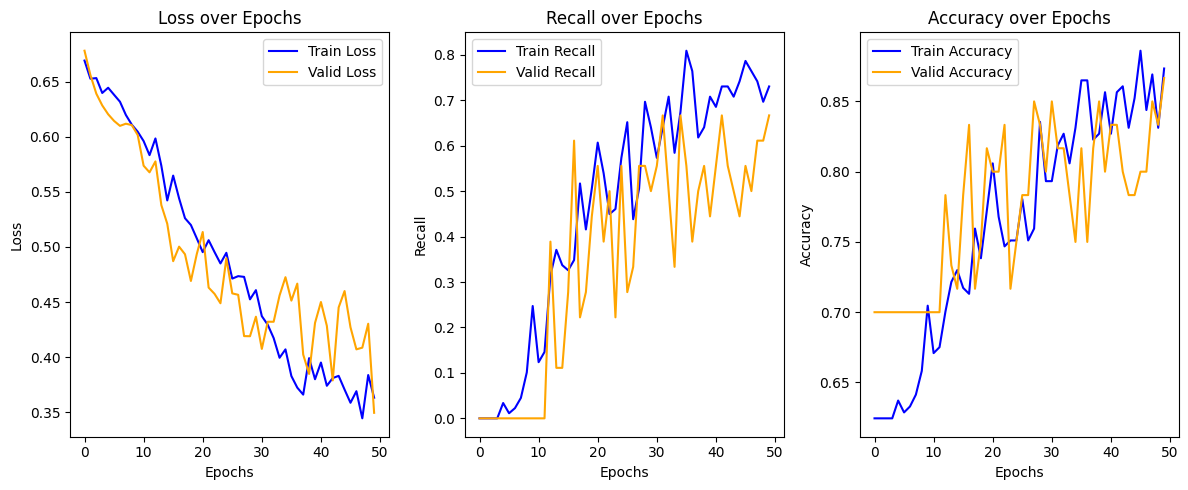

In [ ]:
import matplotlib.pyplot as plt
# Plotting the metrics
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Valid Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 3, 2)
plt.plot(train_recalls, label='Train Recall', color='blue')
plt.plot(val_recalls, label='Valid Recall', color='orange')
plt.title('Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_accs, label='Train Accuracy', color='blue')
plt.plot(val_accs, label='Valid Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'last_model.pth')

<ipython-input-21-6cb73e8fd65a>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


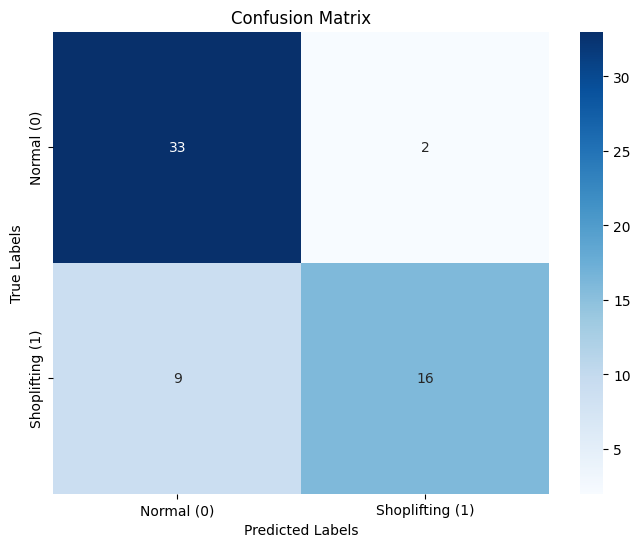

Precision for normal (0): 0.7857
Recall for normal (0): 0.9429
F1 Score for normal (0): 0.8571
Precision for shoplifting (1): 0.8889
Recall for shoplifting (1): 0.6400
F1 Score for shoplifting (1): 0.7442


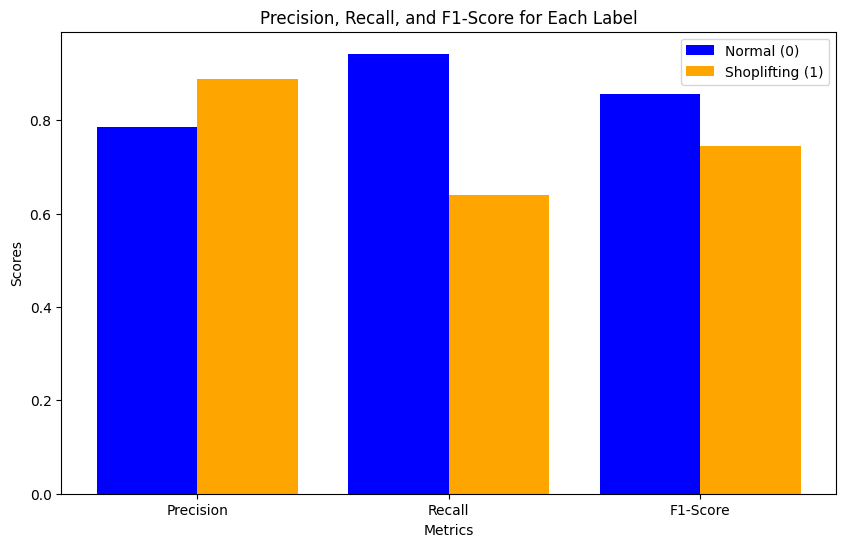

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Lưu trữ các nhãn thực và nhãn dự đoán
all_labels = []
all_preds = []

# Đánh giá trên tập validation
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = [inp.to(device, non_blocking=True) for inp in inputs]
        labels = labels.to(device, non_blocking=True)

        with autocast():
            outputs = model(inputs)

        _, predicted = torch.max(outputs, 1)

        # Lưu nhãn thực và dự đoán
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Chuyển đổi danh sách thành numpy array
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Tính precision, recall và F1 cho từng nhãn
precision_0 = precision_score(all_labels, all_preds, pos_label=0)
recall_0 = recall_score(all_labels, all_preds, pos_label=0)
f1_0 = f1_score(all_labels, all_preds, pos_label=0)

precision_1 = precision_score(all_labels, all_preds, pos_label=1)
recall_1 = recall_score(all_labels, all_preds, pos_label=1)
f1_1 = f1_score(all_labels, all_preds, pos_label=1)

# Vẽ Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal (0)', 'Shoplifting (1)'], yticklabels=['Normal (0)', 'Shoplifting (1)'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Hiển thị Precision, Recall và F1 cho từng nhãn
print(f'Precision for normal (0): {precision_0:.4f}')
print(f'Recall for normal (0): {recall_0:.4f}')
print(f'F1 Score for normal (0): {f1_0:.4f}')

print(f'Precision for shoplifting (1): {precision_1:.4f}')
print(f'Recall for shoplifting (1): {recall_1:.4f}')
print(f'F1 Score for shoplifting (1): {f1_1:.4f}')

# Vẽ barplot cho Precision, Recall, F1-Score
metrics = ['Precision', 'Recall', 'F1-Score']
values_0 = [precision_0, recall_0, f1_0]
values_1 = [precision_1, recall_1, f1_1]

x = range(len(metrics))

plt.figure(figsize=(10, 6))
plt.bar(x, values_0, width=0.4, label='Normal (0)', align='center', color='blue')
plt.bar([i + 0.4 for i in x], values_1, width=0.4, label='Shoplifting (1)', align='center', color='orange')
plt.xticks([i + 0.2 for i in x], metrics)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Precision, Recall, and F1-Score for Each Label')
plt.legend()
plt.show()


In [ ]:
# Tải lại mô hình tốt nhất
model.load_state_dict(torch.load('best_model.pth'))
model.eval()  # Đặt mô hình vào chế độ đánh giá


<ipython-input-22-95fa7e7ca376>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Net(
  (blocks): ModuleList(
    (0): MultiPathWayWithFuse(
      (multipathway_blocks): ModuleList(
        (0): ResNetBasicStem(
          (conv): Conv3d(17, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
          (norm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): ReLU()
        )
        (1): ResNetBasicStem(
          (conv): Conv3d(17, 8, kernel_size=(5, 3, 3), stride=(1, 1, 1), padding=(2, 1, 1), bias=False)
          (norm): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): ReLU()
        )
      )
      (multipathway_fusion): FuseFastToSlow(
        (conv_fast_to_slow): Conv3d(8, 16, kernel_size=(7, 1, 1), stride=(4, 1, 1), padding=(3, 0, 0), bias=False)
        (norm): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
    )
    (1): MultiPathWayWithFuse(
      (multipat

<ipython-input-23-6cb73e8fd65a>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


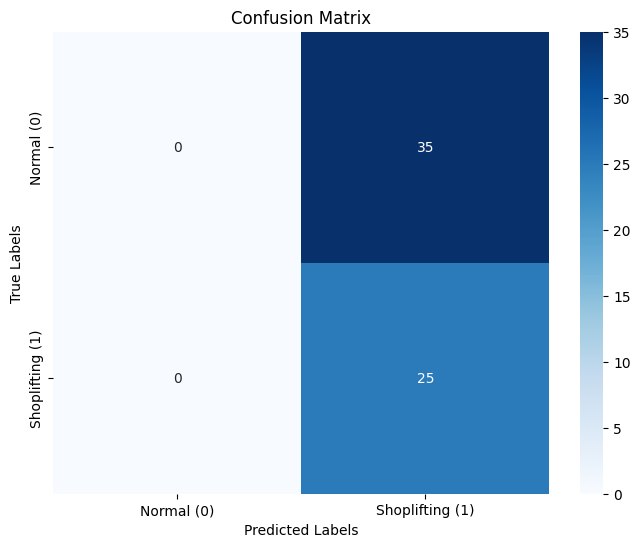

Precision for normal (0): 0.0000
Recall for normal (0): 0.0000
F1 Score for normal (0): 0.0000
Precision for shoplifting (1): 0.4167
Recall for shoplifting (1): 1.0000
F1 Score for shoplifting (1): 0.5882


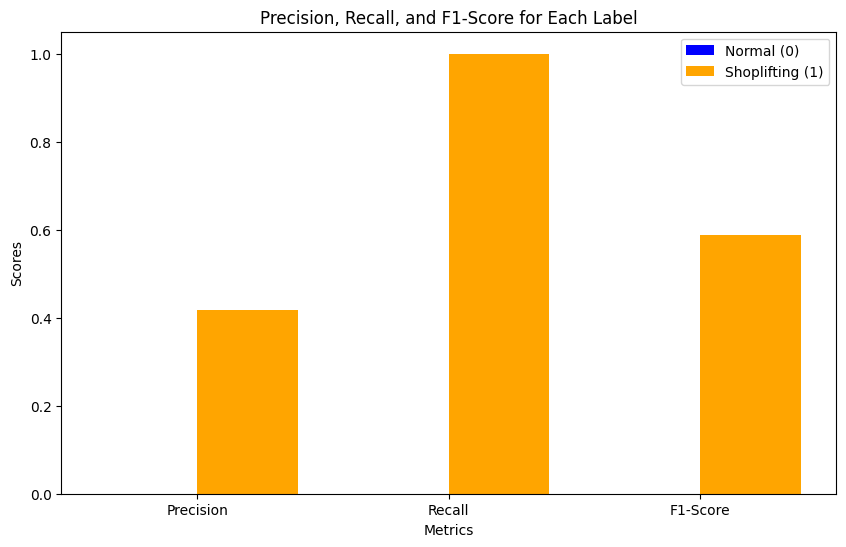

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Lưu trữ các nhãn thực và nhãn dự đoán
all_labels = []
all_preds = []

# Đánh giá trên tập validation
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = [inp.to(device, non_blocking=True) for inp in inputs]
        labels = labels.to(device, non_blocking=True)

        with autocast():
            outputs = model(inputs)

        _, predicted = torch.max(outputs, 1)

        # Lưu nhãn thực và dự đoán
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Chuyển đổi danh sách thành numpy array
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Tính precision, recall và F1 cho từng nhãn
precision_0 = precision_score(all_labels, all_preds, pos_label=0)
recall_0 = recall_score(all_labels, all_preds, pos_label=0)
f1_0 = f1_score(all_labels, all_preds, pos_label=0)

precision_1 = precision_score(all_labels, all_preds, pos_label=1)
recall_1 = recall_score(all_labels, all_preds, pos_label=1)
f1_1 = f1_score(all_labels, all_preds, pos_label=1)

# Vẽ Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal (0)', 'Shoplifting (1)'], yticklabels=['Normal (0)', 'Shoplifting (1)'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Hiển thị Precision, Recall và F1 cho từng nhãn
print(f'Precision for normal (0): {precision_0:.4f}')
print(f'Recall for normal (0): {recall_0:.4f}')
print(f'F1 Score for normal (0): {f1_0:.4f}')

print(f'Precision for shoplifting (1): {precision_1:.4f}')
print(f'Recall for shoplifting (1): {recall_1:.4f}')
print(f'F1 Score for shoplifting (1): {f1_1:.4f}')

# Vẽ barplot cho Precision, Recall, F1-Score
metrics = ['Precision', 'Recall', 'F1-Score']
values_0 = [precision_0, recall_0, f1_0]
values_1 = [precision_1, recall_1, f1_1]

x = range(len(metrics))

plt.figure(figsize=(10, 6))
plt.bar(x, values_0, width=0.4, label='Normal (0)', align='center', color='blue')
plt.bar([i + 0.4 for i in x], values_1, width=0.4, label='Shoplifting (1)', align='center', color='orange')
plt.xticks([i + 0.2 for i in x], metrics)
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Precision, Recall, and F1-Score for Each Label')
plt.legend()
plt.show()
